In [22]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.isotonic import IsotonicRegression
from scipy.spatial import distance
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def ridge_func(x):
    return np.maximum(0, x)
    
def generate_synthetic_data(n, d, alpha_0_true, noise_scale=0.2, distribution='uniform', gamma_shape=2.0, gamma_scale=1.0):
    np.random.seed(567)
    if distribution == 'uniform':
        X = np.random.rand(n, d)  # Uniform distribution in [0, 1)
    elif distribution == 'normal':
        X = np.random.randn(n, d)  # Standard normal distribution
    elif distribution == 'gamma':
        X = np.random.gamma(gamma_shape, gamma_scale, (n, d))  # Gamma distribution
    else:
        raise ValueError("Unsupported distribution type. Please choose either 'uniform', 'normal', or 'gamma'.")
    
    Y = ridge_func(X.dot(alpha_0_true)) + np.random.normal(scale=noise_scale, size=n)
    return X, Y

import numpy as np

def find_orthogonal_vectors_with_midpoints(X):
    n, d = X.shape
    orthogonal_vectors = set()
    for i in range(n):
        for j in range(n):
            if j !=i : 
                diff = X[j] - X[i]
                ortho_vector = np.array([-diff[1], diff[0]])  # For d=2
                ortho_vector /= np.linalg.norm(ortho_vector)  # Normalize
                orthogonal_vectors.add(tuple(ortho_vector))
    
    orthogonal_vectors = np.array(list(orthogonal_vectors))

    # Convert orthogonal vectors to polar coordinates and find midpoints
    def cartesian_to_polar_midpoints(vectors):
        angles = np.arctan2(vectors[:, 1], vectors[:, 0])
        angles = np.mod(angles, 2 * np.pi)
        sorted_angles = np.sort(angles)
        midpoints = (sorted_angles + np.roll(sorted_angles, -1)) / 2
        midpoints[-1] = (midpoints[-1] + np.pi) % (2 * np.pi)
        return midpoints

    midpoints = cartesian_to_polar_midpoints(orthogonal_vectors)

    # Convert midpoints back to Cartesian coordinates
    midpoint_vectors = np.column_stack((np.cos(midpoints), np.sin(midpoints)))

    return midpoint_vectors

def compute_mse(Y_true, Y_pred):
    return np.mean((Y_true - Y_pred)**2)


### Uniform(0,1) distributed X

In [23]:

# Generate synthetic data
n, d = 500, 2
alpha_0_true = np.array([1, -1])
alpha_0_true = alpha_0_true/np.linalg.norm(alpha_0_true) 
X, Y = generate_synthetic_data(n, d, alpha_0_true, distribution = 'uniform')

# Find orthogonal vectors
orthogonal_vectors = find_orthogonal_vectors_with_midpoints(X)

# Main algorithm loop
best_mse = np.inf
best_alpha = None
best_Y_pred = None

for alpha in orthogonal_vectors:
    # Project X onto alpha
    projected_X = X.dot(alpha)
    
    # Apply isotonic regression
    iso_reg = IsotonicRegression(increasing=True, out_of_bounds='clip')
    Y_pred = iso_reg.fit_transform(projected_X, Y)

    # Compute MSE and update best alpha if needed
    mse = compute_mse(Y, Y_pred)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_iso_reg = iso_reg
        best_Y_pred = Y_pred

print("Ground Truth Alpha: ", alpha_0_true)
print("Best alpha:", best_alpha)
print("MSE:", best_mse)


Ground Truth Alpha:  [ 0.70710678 -0.70710678]
Best alpha: [ 0.76271025 -0.64674034]
MSE: 0.043560716880071806


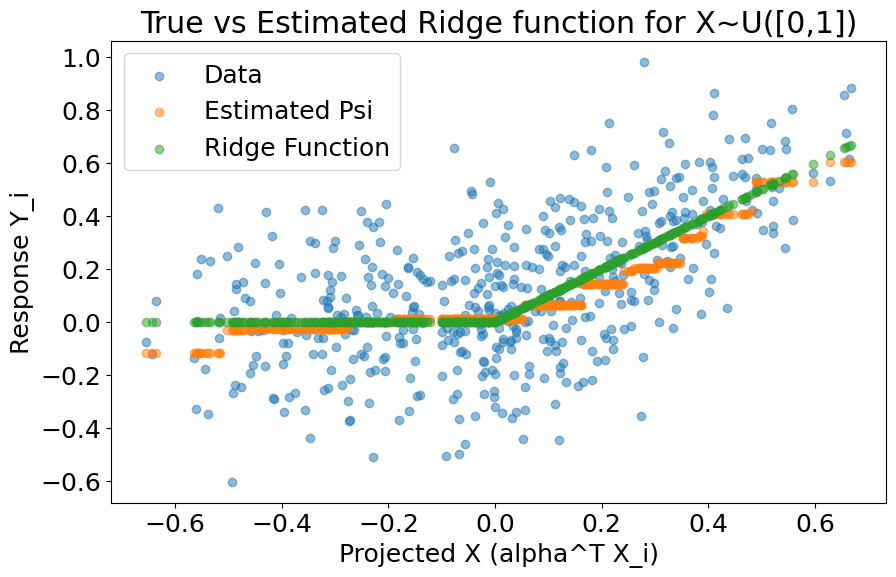

In [24]:
# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.scatter(X.dot(alpha_0_true), best_iso_reg.predict( X.dot(alpha_0_true) ), alpha=0.5, label='Estimated Psi')
plt.scatter(X.dot(alpha_0_true), ridge_func(X.dot(alpha_0_true)), alpha=0.5, label='Ridge Function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('True vs Estimated Ridge function for X~U([0,1])')
plt.legend()
plt.show()


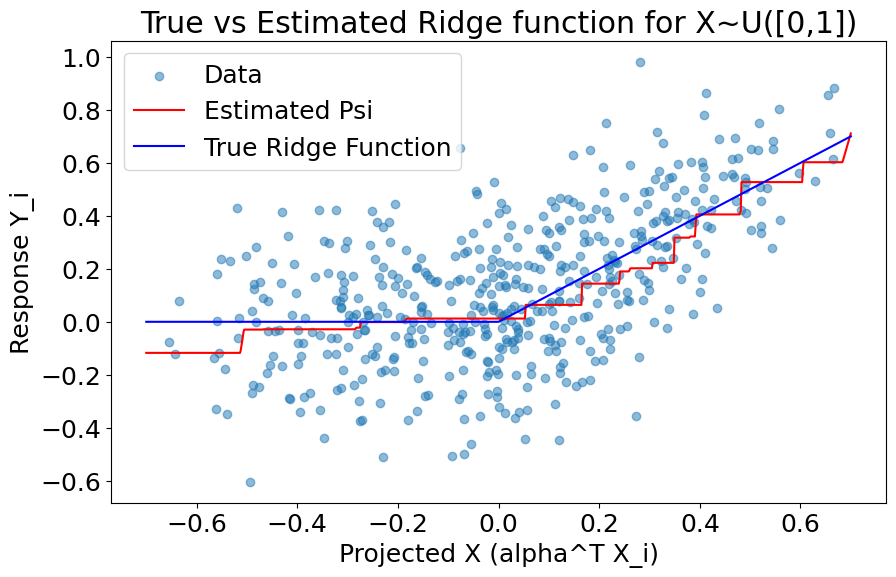

In [25]:
points = np.linspace(-0.7, 0.7, 1000)

# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.plot(points, best_iso_reg.predict(points), color='red', label='Estimated Psi')
plt.plot(points, ridge_func(points), color='blue', label='True Ridge Function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('True vs Estimated Ridge function for X~U([0,1])')
plt.legend()
plt.show()


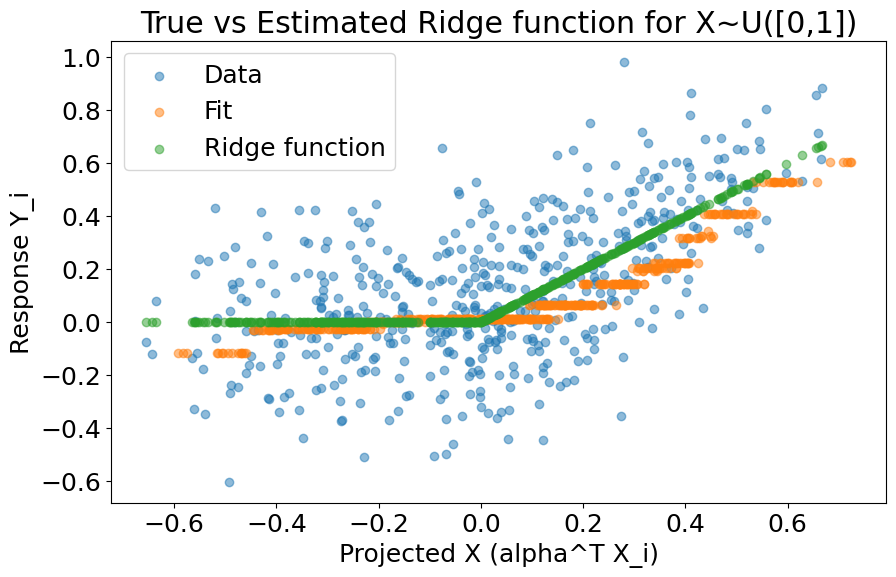

In [26]:
# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.scatter(X.dot(best_alpha), best_iso_reg.predict( X.dot(alpha_0_true) ), alpha=0.5, label='Fit')
plt.scatter(X.dot(alpha_0_true), ridge_func(X.dot(alpha_0_true)), alpha=0.5, label='Ridge function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('True vs Estimated Ridge function for X~U([0,1])')
plt.legend()
plt.show()


In [27]:
def mse_for_different_n(n_values, alpha_0_true, distr, total_train_size=1000, d=2, noise_scale=0.2):
    mse_values = []
    
    np.random.seed(567)
    # Generate a large set of training data only once
    X_train_full, Y_train_full = generate_synthetic_data(total_train_size, d, alpha_0_true, noise_scale=noise_scale, distribution=distr)

    # Generate unseen data (test data)
    X_test, Y_test = generate_synthetic_data(1000, d, alpha_0_true, noise_scale=noise_scale, distribution=distr)

    for n in n_values:
        # Take a subset of the training data
        X_train_subset = X_train_full[:n]
        Y_train_subset = Y_train_full[:n]

        # Find orthogonal vectors and midpoints
        midpoint_vectors = find_orthogonal_vectors_with_midpoints(X_train_subset)

        # Main algorithm loop using midpoint_vectors
        best_mse = np.inf
        for alpha in midpoint_vectors:
            # Project X onto alpha for training data
            projected_X_train_subset = X_train_subset.dot(alpha)
            
            # Apply isotonic regression
            iso_reg = IsotonicRegression(increasing=True, out_of_bounds='clip').fit(projected_X_train_subset, Y_train_subset)

            # Project X onto alpha for test data
            projected_X_test = X_test.dot(alpha)
            Y_pred_test = iso_reg.predict(projected_X_test)
            
            # Compute MSE on test data and update best alpha if needed
            mse = mean_squared_error(Y_test, Y_pred_test)
            if mse < best_mse:
                best_mse = mse

        mse_values.append(best_mse)

    return mse_values


In [28]:
# Define the parameters
n_values = [50, 100, 150, 200, 250,  500, 1000]

# Compute MSE values for different n
mse_values = mse_for_different_n(n_values, alpha_0_true, distr='uniform')

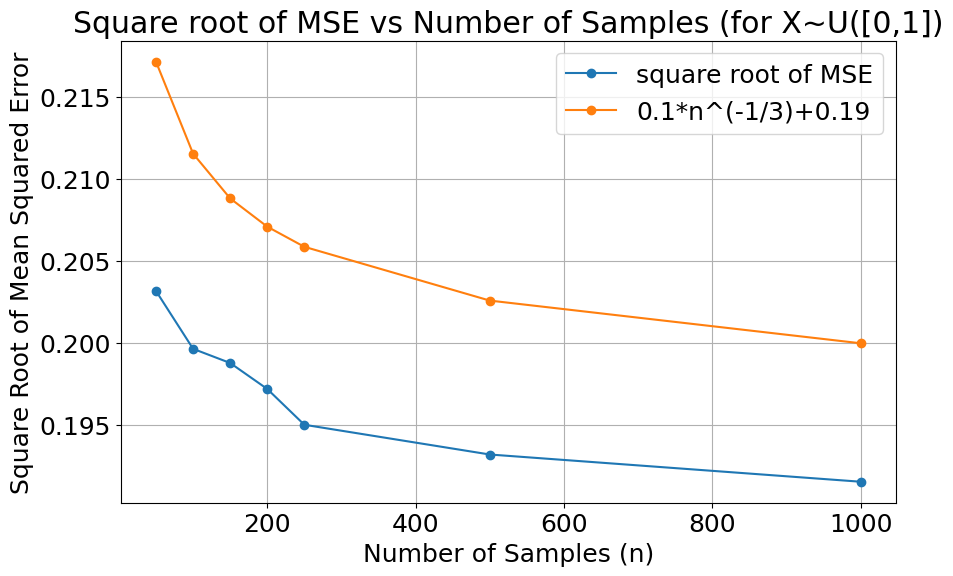

In [29]:
mse_sqrt_values = np.sqrt(mse_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_sqrt_values, marker='o', label="square root of MSE")
plt.plot(n_values, 0.1*np.array(n_values)**(-1/3)+0.19, marker='o', label = "0.1*n^(-1/3)+0.19")
plt.xlabel('Number of Samples (n)')
plt.ylabel('Square Root of Mean Squared Error')
plt.title('Square root of MSE vs Number of Samples (for X~U([0,1])')
plt.grid(True)
plt.legend()
plt.show()

### Gaussian Distributed X

In [30]:
# Generate synthetic data
X, Y = generate_synthetic_data(n, d, alpha_0_true, distribution='normal')

# Find orthogonal vectors
orthogonal_vectors = find_orthogonal_vectors_with_midpoints(X)

# Main algorithm loop
best_mse = np.inf
best_alpha = None
best_Y_pred = None

for alpha in orthogonal_vectors:
    # Project X onto alpha
    projected_X = X.dot(alpha)
    
    # Apply isotonic regression
    iso_reg = IsotonicRegression(increasing=True, out_of_bounds='clip')
    Y_pred = iso_reg.fit_transform(projected_X, Y)

    # Compute MSE and update best alpha if needed
    mse = compute_mse(Y, Y_pred)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_iso_reg = iso_reg
        best_Y_pred = Y_pred

print("Ground Truth Alpha: ", alpha_0_true)
print("Best alpha:", best_alpha)
print("MSE:", best_mse)

Ground Truth Alpha:  [ 0.70710678 -0.70710678]
Best alpha: [ 0.72245691 -0.69141595]
MSE: 0.0395302279501622


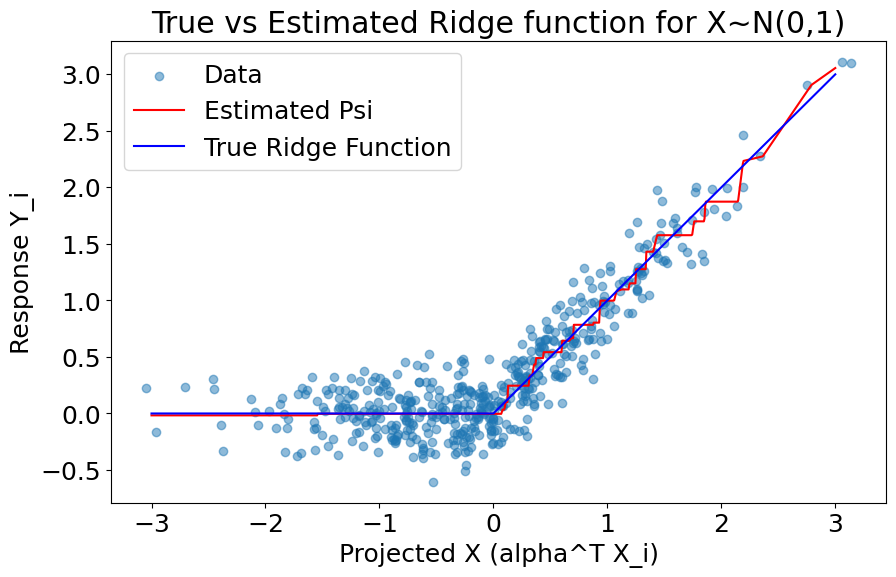

In [31]:
points = np.linspace(-3, 3, 1000)

# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.plot(points, best_iso_reg.predict(points), color='red', label='Estimated Psi')
plt.plot(points, ridge_func(points), color='blue', label='True Ridge Function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('True vs Estimated Ridge function for X~N(0,1)')
plt.legend()
plt.show()


In [32]:
# Compute MSE values for different n
mse_values = mse_for_different_n(n_values, alpha_0_true, distr = "normal")

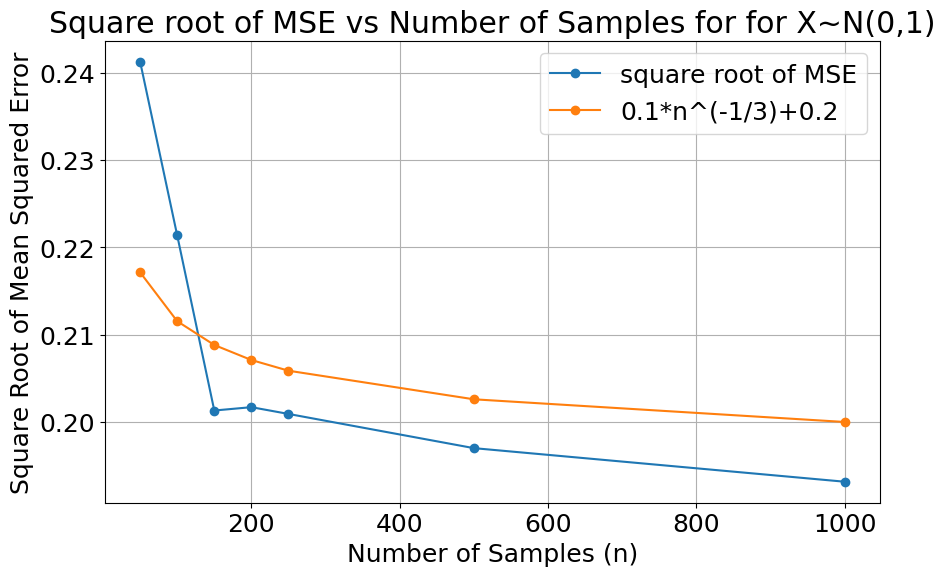

In [33]:
mse_sqrt_values = np.sqrt(mse_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_sqrt_values, marker='o', label="square root of MSE")
plt.plot(n_values, 0.1*np.array(n_values)**(-1/3)+0.19, marker='o', label = "0.1*n^(-1/3)+0.2")
plt.xlabel('Number of Samples (n)')
plt.ylabel('Square Root of Mean Squared Error')
plt.title('Square root of MSE vs Number of Samples for for X~N(0,1)')
plt.grid(True)
plt.legend()
plt.show()

### Gamma distributed X

In [34]:
# Generate synthetic data
X, Y = generate_synthetic_data(n, d, alpha_0_true, distribution='gamma')

# Find orthogonal vectors
orthogonal_vectors = find_orthogonal_vectors_with_midpoints(X)

# Main algorithm loop
best_mse = np.inf
best_alpha = None
best_Y_pred = None

for alpha in orthogonal_vectors:
    # Project X onto alpha
    projected_X = X.dot(alpha)
    
    # Apply isotonic regression
    iso_reg = IsotonicRegression(increasing=True, out_of_bounds='clip')
    Y_pred = iso_reg.fit_transform(projected_X, Y)

    # Compute MSE and update best alpha if needed
    mse = compute_mse(Y, Y_pred)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_iso_reg = iso_reg
        best_Y_pred = Y_pred

print("Ground Truth Alpha: ", alpha_0_true)
print("Best alpha:", best_alpha)
print("MSE:", best_mse)


Ground Truth Alpha:  [ 0.70710678 -0.70710678]
Best alpha: [ 0.67652408 -0.73642051]
MSE: 0.035339432916698145


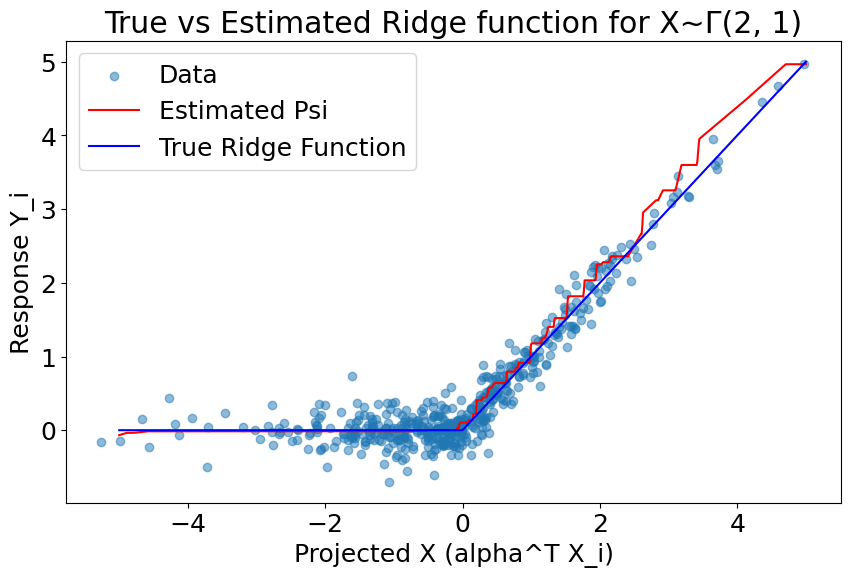

In [42]:
points = np.linspace(-5, 5, 1000)

# Visualization of the synthetic data (alpha^T X_i vs Y_i)
plt.figure(figsize=(10, 6))
plt.scatter(X.dot(alpha_0_true), Y, alpha=0.5, label='Data')
plt.plot(points, best_iso_reg.predict(points), color='red', label='Estimated Psi')
plt.plot(points, ridge_func(points), color='blue', label='True Ridge Function')

plt.xlabel('Projected X (alpha^T X_i)')
plt.ylabel('Response Y_i')
plt.title('True vs Estimated Ridge function for X~Γ(2, 1)')
plt.legend()
plt.show()


In [36]:
# Compute MSE values for different n
mse_values = mse_for_different_n(n_values, alpha_0_true, distr="gamma")

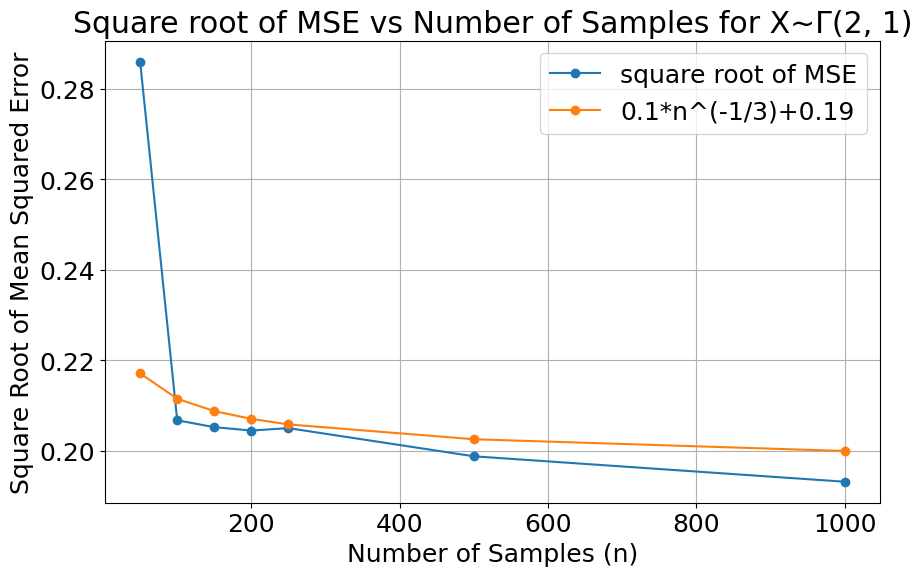

In [37]:
mse_sqrt_values = np.sqrt(mse_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, mse_sqrt_values, marker='o', label="square root of MSE")
plt.plot(n_values, 0.1*np.array(n_values)**(-1/3)+0.19, marker='o', label = "0.1*n^(-1/3)+0.19")
plt.xlabel('Number of Samples (n)')
plt.ylabel('Square Root of Mean Squared Error')
plt.title('Square root of MSE vs Number of Samples for X~Γ(2, 1)')
plt.grid(True)
plt.legend()
plt.show()